# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

The notebook pulls data from the John Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases, and then does the following things:

- List total number of confirmed cases (in countries with at least 100 cases)
- Attempt to fit the time series of confirmed cases in these countries to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of confirmed cases to double)
- If the curve fit was successful, summarize doubling times for each country

We then repeat the following steps for the US:
- List total number of confirmed cases by US state & list US locations with the most cases
- Attempt to fit the time series of confirmed US cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of confirmed cases to double)
- If the curve fit was successful, summarize doubling times for each US state with at least 50 cases

The main finding is that the doubling time of confirmed cases for countries with at least 100 cases is roughly 2 days.

The notebook is updated every evening Eastern Time.

**Note: For countries where the cases have peaked (such as Mainland China), the inferred growth rate is not the current growth rate. Instead, it's the growth rate encountered at early stages of the epidemic (i.e., in the past).**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [3]:
for index, row in df.iterrows():
    if row['Country/Region'] == 'Others':
        a = row['Province/State']
        df.loc[index, 'Country/Region'] = a

## Global COVID-19 Analysis

In [4]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/6/20


,3/6/20
Country/Region,
Mainland China,80573.0
South Korea,6593.0
Iran,4747.0
Italy,4636.0
Diamond Princess cruise ship,696.0
Germany,670.0
France,653.0
Japan,420.0
Spain,400.0


## Curve Fitting Global COVID-19 Cases

In [5]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        ldoubletime = np.log(2)/lpopt[1]
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.9:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit **\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time: ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        edoubletime = np.log(2)/epopt[1]
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.9:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Curve Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time: ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' COVID-19 Cases as of '+mostrecentdate, fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if logisticr2 > expr2:
            return [ldoubletime, ldoubletimeerror]
        else:
            return [edoubletime, edoubletimeerror]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror]



Mainland China

** Based on Logistic Fit **

	R^2: 0.994079000153
	Doubling Time:  3.23 (± 0.35 ) days


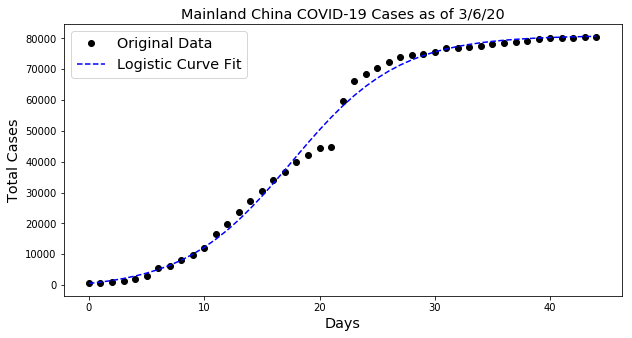



South Korea

** Based on Logistic Fit **

	R^2: 0.999278578353
	Doubling Time:  1.86 (± 0.08 ) days

** Based on Exponential Curve Fit **

	R^2: 0.976162859333
	Doubling Time:  4.16 (± 0.42 ) days


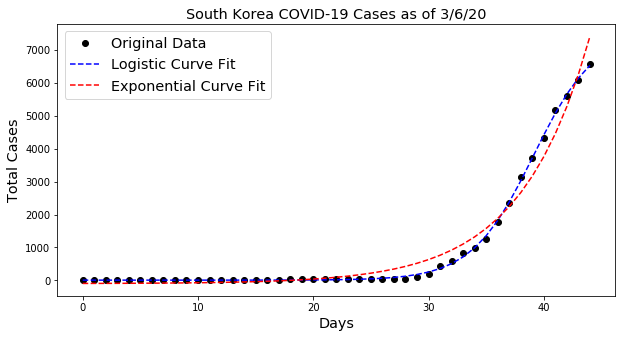



Iran

** Based on Logistic Fit **

	R^2: 0.996199739431
	Doubling Time:  1.51 (± 0.3 ) days

** Based on Exponential Curve Fit **

	R^2: 0.990469768136
	Doubling Time:  2.39 (± 0.3 ) days


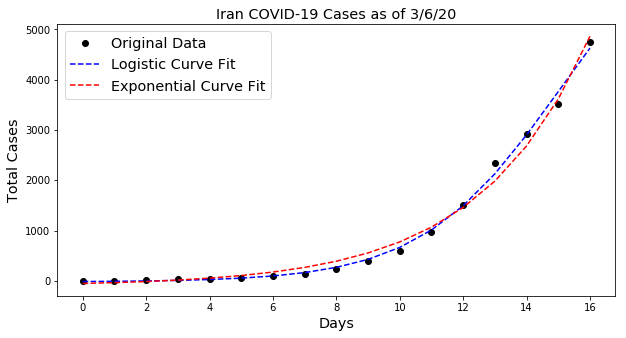



Italy

** Based on Logistic Fit **

	R^2: 0.99882050984
	Doubling Time:  2.14 (± 0.14 ) days

** Based on Exponential Curve Fit **

	R^2: 0.99495614027
	Doubling Time:  3.03 (± 0.16 ) days


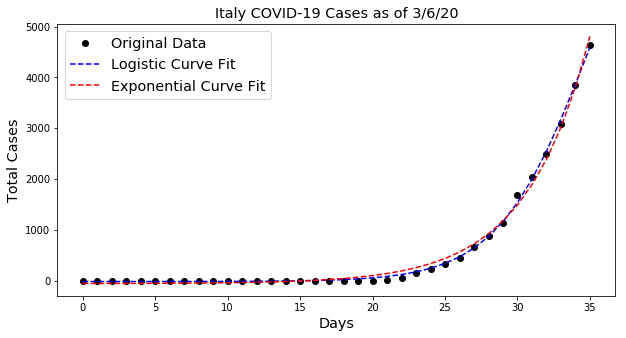



Diamond Princess cruise ship

** Based on Logistic Fit **

	R^2: 0.995064845317
	Doubling Time:  1.37 (± 0.18 ) days


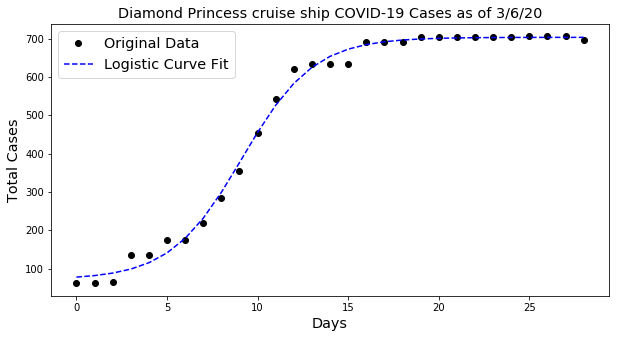



Germany

** Based on Exponential Curve Fit **

	R^2: 0.992972810243
	Doubling Time:  1.73 (± 0.1 ) days


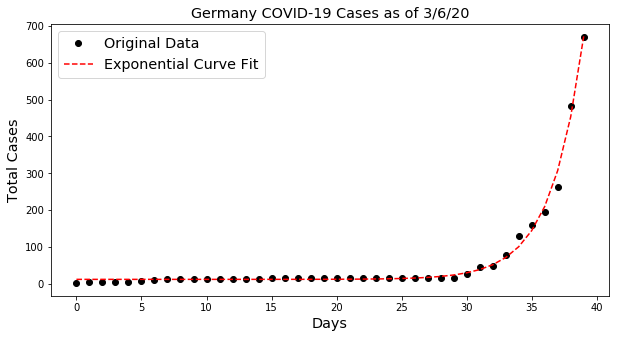



France

** Based on Exponential Curve Fit **

	R^2: 0.987417838351
	Doubling Time:  1.9 (± 0.14 ) days


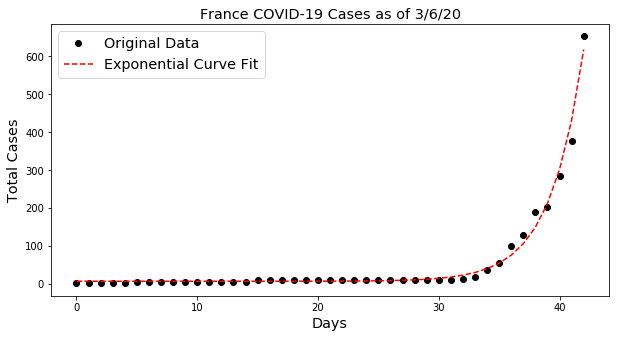



Japan

** Based on Logistic Fit **

	R^2: 0.992559254687
	Doubling Time:  5.53 (± 1.04 ) days

** Based on Exponential Curve Fit **

	R^2: 0.991174840263
	Doubling Time:  7.61 (± 0.56 ) days


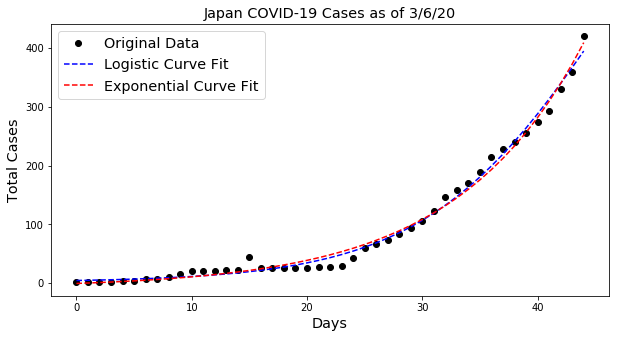



Spain

** Based on Exponential Curve Fit **

	R^2: 0.992192060842
	Doubling Time:  2.14 (± 0.14 ) days


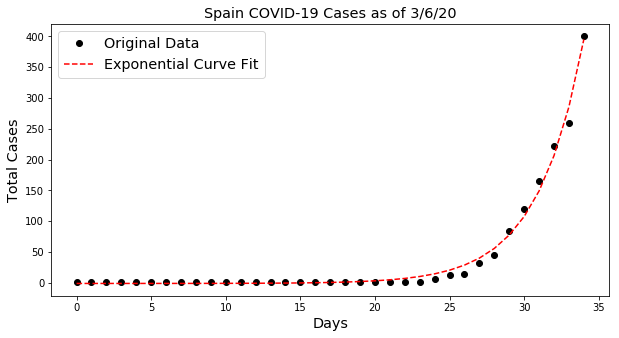



US

** Based on Exponential Curve Fit **

	R^2: 0.977178633239
	Doubling Time:  3.03 (± 0.29 ) days


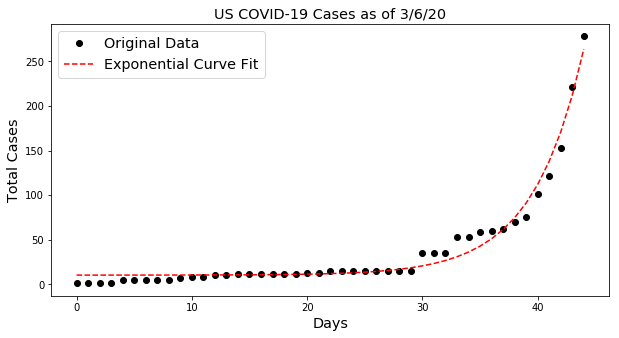



Switzerland

** Based on Logistic Fit **

	R^2: 0.987945550066
	Doubling Time:  1.53 (± 0.54 ) days

** Based on Exponential Curve Fit **

	R^2: 0.987945551537
	Doubling Time:  1.53 (± 0.29 ) days


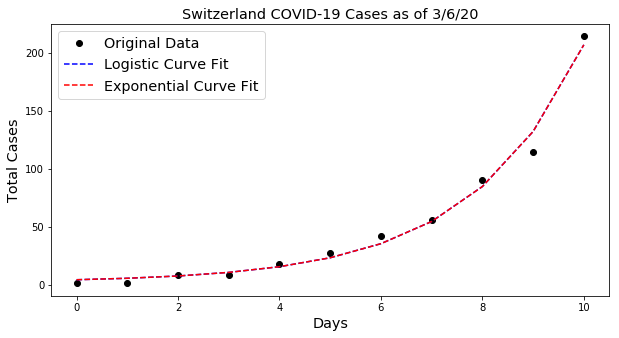



UK

** Based on Exponential Curve Fit **

	R^2: 0.991325622265
	Doubling Time:  1.91 (± 0.13 ) days


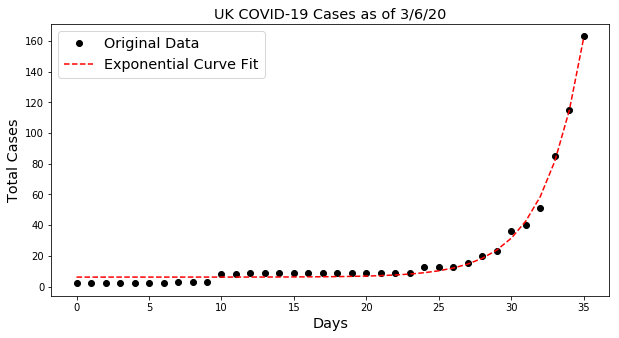



Singapore

** Based on Logistic Fit **

	R^2: 0.986289630973
	Doubling Time:  6.26 (± 1.58 ) days

** Based on Exponential Curve Fit **

	R^2: 0.965573046362
	Doubling Time:  36.05 (± 19.59 ) days


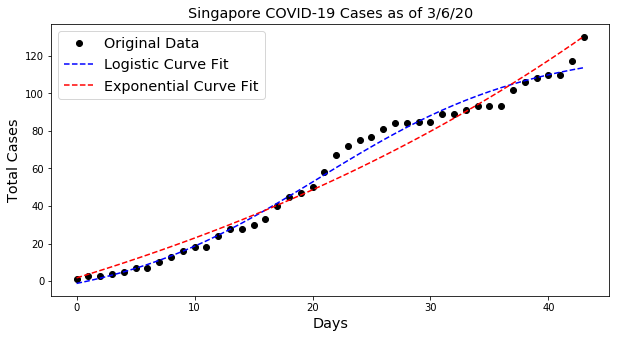



Netherlands

** Based on Logistic Fit **

	R^2: 0.994003137443
	Doubling Time:  1.01 (± 0.56 ) days

** Based on Exponential Curve Fit **

	R^2: 0.993422261056
	Doubling Time:  1.3 (± 0.22 ) days


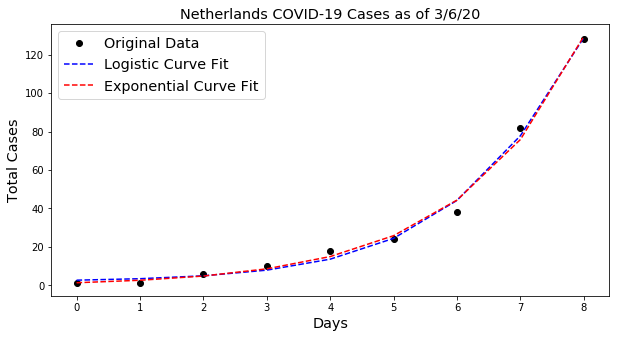



Belgium

** Based on Exponential Curve Fit **

	R^2: 0.999197941668
	Doubling Time:  0.89 (± 0.02 ) days


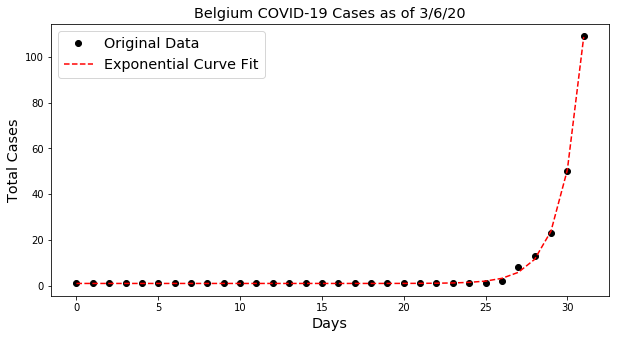



Norway

** Based on Logistic Fit **

	R^2: 0.990174450417
	Doubling Time:  1.35 (± 0.85 ) days

** Based on Exponential Curve Fit **

	R^2: 0.988445866405
	Doubling Time:  2.18 (± 0.54 ) days


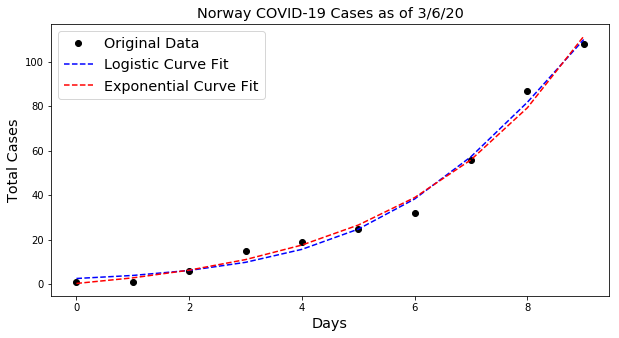



Hong Kong

** Based on Logistic Fit **

	R^2: 0.990873541253
	Doubling Time:  7.14 (± 1.71 ) days

** Based on Exponential Curve Fit **

	R^2: 0.982524557712
	Doubling Time:  38.61 (± 15.78 ) days


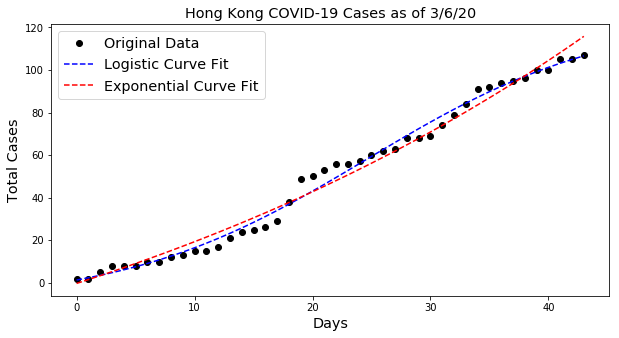



Sweden

** Based on Exponential Curve Fit **

	R^2: 0.953377815137
	Doubling Time:  1.56 (± 0.25 ) days


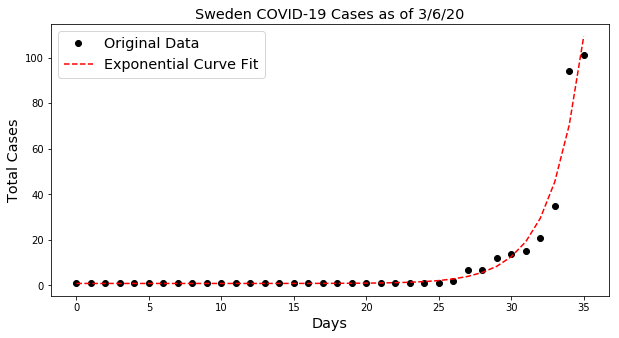

In [6]:
topcountries = cases.index
doublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        doublingtime.append(a[0])
        errors.append(a[1])
    print('\n')

## Doubling Times for Global COVID-19 Cases

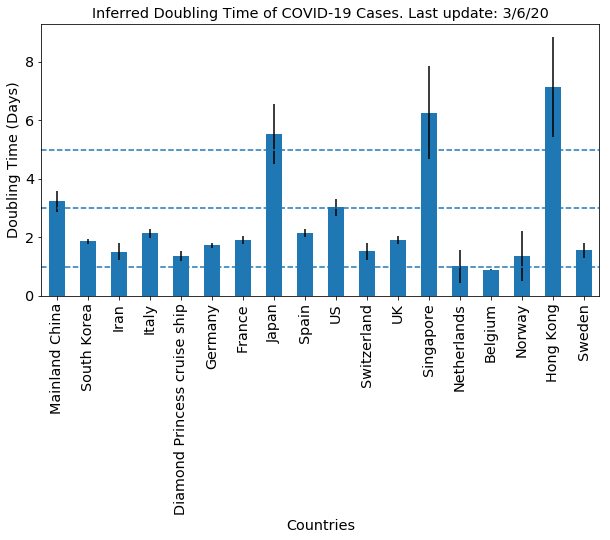

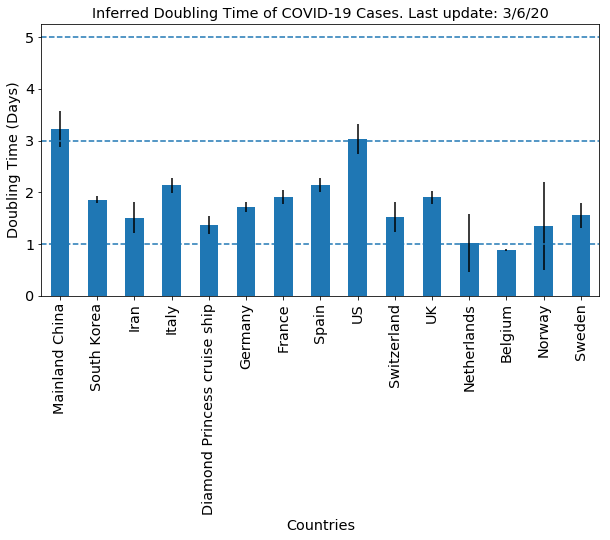

In [7]:
d = {'Countries': countries, 'Doubling Time': doublingtime, '95%CI': errors}

print('\n')
dt = pd.DataFrame(data = d)
dt.plot.bar(x = 'Countries', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Doubling Time'] < 5]
dt.plot.bar(x = 'Countries', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [8]:
uscases = df[df['Country/Region'] == 'US']

uscasesbystate = uscases.copy()
uscasesbystate['Province/State'] = uscasesbystate['Province/State'].str.split(", ", expand=True)[1]

usstatesummary = uscasesbystate.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/6/20


,3/6/20
Province/State,
WA,83.0
CA,59.0
NY,36.0
MA,7.0
IL,5.0
TX,5.0
FL,4.0
CO,4.0
GA,3.0


In [9]:
uscitysummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = uscitysummary.columns[0]
uscitysummary = uscitysummary.sort_values(by = mostrecentdate, ascending = False)
uscitysummary = uscitysummary[uscitysummary[mostrecentdate] >= 5]

print('\nUS Locations with 5 or more confirmed cases as of', mostrecentdate)

uscitysummary


US Locations with 5 or more confirmed cases as of 3/6/20


,3/6/20
Province/State,
"King County, WA",58.0
Unassigned Location (From Diamond Princess),45.0
"Santa Clara, CA",20.0
"Westchester County, NY",19.0
"Snohomish County, WA",19.0
"New York County, NY",16.0
"Los Angeles, CA",13.0
"Placer County, CA",5.0
"Cook County, IL",5.0


## Curve Fitting US COVID-19 Cases



US state:  WA

** Based on Exponential Curve Fit **

	R^2: 0.984911394893
	Doubling Time:  1.73 (± 0.13 ) days


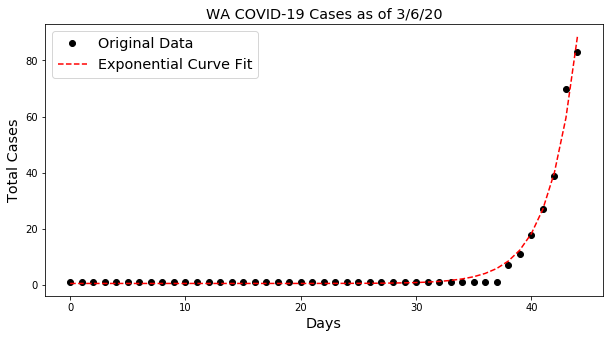



US state:  CA

** Based on Exponential Curve Fit **

	R^2: 0.957969015088
	Doubling Time:  2.15 (± 0.3 ) days


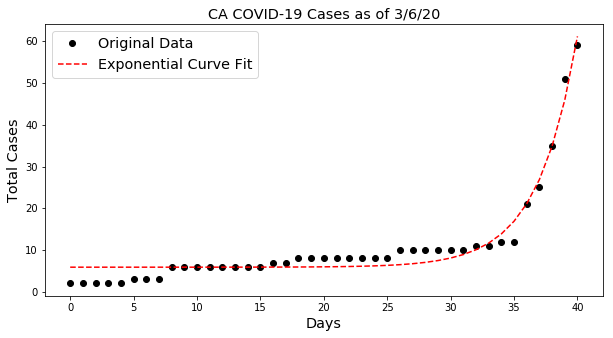

In [10]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 50]
print('\n');
doublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscasesbystate,'Province/State', state)
    if a:
        states.append(state)
        doublingtime.append(a[0])
        errors.append(a[1])
    print('\n')

## Doubling Times for US COVID-19 Cases

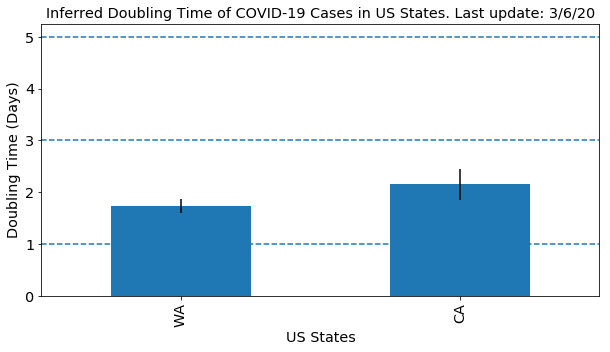

In [11]:
d = {'States': states, 'Doubling Time': doublingtime, '95%CI': errors}

print('\n')
dt = pd.DataFrame(data = d)
dt.plot.bar(x = 'States', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()
